<font size="5.5"><u><i>Noise Explorer</i></u></font>

<font size="4">Exploratory analysis of noise strain data obtained from the Gravitational Wave Open Science Center.</font>
<br/>
<font size="4">Author: Manuel David Morales</font>

## 1. Library imports

In [1]:
# Data analysis
import numpy as np 
import pandas as pd

# Visualization
import matplotlib.pyplot as plt

# Files/folders management
import h5py
import os, glob, sys

# Garbage collector
import gc

# GW standard tools
import pycbc
import pycbc.psd

# Toolbox functions
from Toolbox import PSD, files_from_url

## 2. Download files from GWOSC

In [2]:
# ------> Set GPS start of the noise data segment
#         Remark: Ensure that the segment, for all interferometers, is 100% available.

GPS_start = "1257050112" # Options: "1256783872", "1257050112"

URL_H1 = "https://gwosc.org/archive/data/O3b_4KHZ_R1/1256194048/H-H1_GWOSC_O3b_4KHZ_R1-" + GPS_start + "-4096.hdf5"
URL_L1 = "https://gwosc.org/archive/data/O3b_4KHZ_R1/1256194048/L-L1_GWOSC_O3b_4KHZ_R1-" + GPS_start + "-4096.hdf5"
URL_V1 = "https://gwosc.org/archive/data/O3b_4KHZ_R1/1256194048/V-V1_GWOSC_O3b_4KHZ_R1-" + GPS_start + "-4096.hdf5"

# ------> Download data

strain_noise_H1, gpsStart_H1, duration_H1, strain_ts_H1 = files_from_url(URL_H1)
strain_noise_L1, gpsStart_L1, duration_L1, strain_ts_L1 = files_from_url(URL_L1)
strain_noise_V1, gpsStart_V1, duration_V1, strain_ts_V1 = files_from_url(URL_V1)

print("")

# ------> Show some prints

# H1 detector
print("H1 detector")
print("--------------")

print("Noise sampling time (in seconds):", strain_ts_H1)
print("GPS start time:", gpsStart_H1)
print("Segment duration (in seconds):", duration_H1)
print("Number of samples in time series:", len(strain_noise_H1))
print("")

# L1 detector
print("L1 detector")
print("--------------")

print("Noise sampling time (in seconds):", strain_ts_L1)
print("GPS start time:", gpsStart_L1)
print("Segment duration (in seconds):", duration_L1)
print("Number of samples in time series:", len(strain_noise_L1))
print("")

# V1 detector
print("V1 detector")
print("--------------")

print("Noise sampling time (in seconds):", strain_ts_V1)
print("GPS start time:", gpsStart_V1)
print("Segment duration (in seconds):", duration_V1)
print("Number of samples in time series:", len(strain_noise_V1))

File Keys: <KeysViewHDF5 ['meta', 'quality', 'strain']>
File Keys: <KeysViewHDF5 ['meta', 'quality', 'strain']>
File Keys: <KeysViewHDF5 ['meta', 'quality', 'strain']>

H1 detector
--------------
Noise sampling time (in seconds): 0.000244140625
GPS start time: 1257050112
Segment duration (in seconds): 4096
Number of samples in time series: 16777216

L1 detector
--------------
Noise sampling time (in seconds): 0.000244140625
GPS start time: 1257050112
Segment duration (in seconds): 4096
Number of samples in time series: 16777216

V1 detector
--------------
Noise sampling time (in seconds): 0.000244140625
GPS start time: 1257050112
Segment duration (in seconds): 4096
Number of samples in time series: 16777216


## 4. Compute PSD

In [3]:
# ------> Input values

# Sampling frequencies
fs_H1 = 1/strain_ts_H1
fs_L1 = 1/strain_ts_L1
fs_V1 = 1/strain_ts_V1

# Size of Welch's segments in sample units
nperseg_H1 = int(4*fs_H1)
nperseg_L1 = int(4*fs_L1)
nperseg_V1 = int(4*fs_V1)

### 4.1. Scipy implementation

In [4]:
%%script false --no-raise-error # WARNING: DEACTIVATED CELL

# ------> PSD Calculation

# Double-sided power spectral density of raw strain data
fpsd_H1, psd_H1 = PSD(strain_noise_H1,fs_H1,nperseg_H1,2)
fpsd_L1, psd_L1 = PSD(strain_noise_L1,fs_L1,nperseg_L1,2)
fpsd_V1, psd_V1 = PSD(strain_noise_V1,fs_V1,nperseg_V1,2)

# Sort arrays, increasing frequencies
ind_raw = np.argsort(fpsd_H1); fpsd_H1 = np.sort(fpsd_H1); psd_H1 = psd_H1[ind_raw]
ind_raw = np.argsort(fpsd_L1); fpsd_L1 = np.sort(fpsd_L1); psd_L1 = psd_L1[ind_raw]
ind_raw = np.argsort(fpsd_V1); fpsd_V1 = np.sort(fpsd_V1); psd_V1 = psd_V1[ind_raw]

### 4.2. PyCBC implementation

In [5]:
# ------> Convert numpy arrays to time series

Noise_H1_series =  pycbc.types.TimeSeries(strain_noise_H1, delta_t = strain_ts_H1)
Noise_L1_series =  pycbc.types.TimeSeries(strain_noise_L1, delta_t = strain_ts_L1)
Noise_V1_series =  pycbc.types.TimeSeries(strain_noise_V1, delta_t = strain_ts_V1)

# ------> Welch's Power Spectral Density estimate

psd_H1_pycbc  = pycbc.psd.welch(Noise_H1_series, seg_len=int(nperseg_H1), seg_stride=int(nperseg_H1*0.5))
fpsd_H1_pycbc = psd_H1_pycbc.sample_frequencies

psd_L1_pycbc  = pycbc.psd.welch(Noise_L1_series, seg_len=int(nperseg_L1), seg_stride=int(nperseg_L1*0.5))
fpsd_L1_pycbc = psd_L1_pycbc.sample_frequencies

psd_V1_pycbc  = pycbc.psd.welch(Noise_V1_series, seg_len=int(nperseg_V1), seg_stride=int(nperseg_V1*0.5))
fpsd_V1_pycbc = psd_V1_pycbc.sample_frequencies

## 5. Explore strain data and PSD

In [7]:
# ------> Create time arrays

time_H1 = np.arange(0.0, duration_H1, strain_ts_H1)
time_L1 = np.arange(0.0, duration_L1, strain_ts_L1)
time_V1 = np.arange(0.0, duration_V1, strain_ts_V1)

# Select No. of strain data samples to plot
Nsamples = 10000

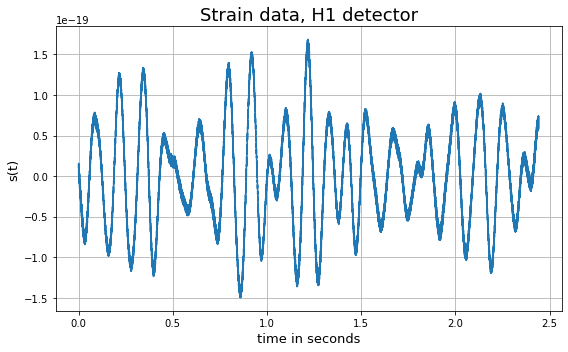

Number of points in time series: 16777216


<Figure size 432x288 with 0 Axes>

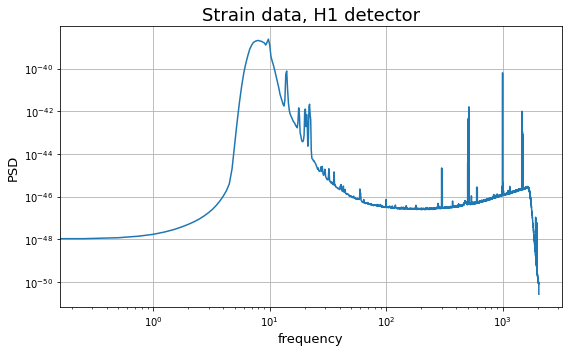

13336

<Figure size 432x288 with 0 Axes>

In [8]:
# ------> H1 detector

plt.figure(1, figsize=(8,5))
plt.plot(time_H1[:Nsamples], strain_noise_H1[:Nsamples])
plt.title("Strain data, H1 detector", fontsize=18)
plt.ylabel("s(t)", fontsize=13)
plt.xlabel("time in seconds", fontsize=13)
plt.grid()
plt.tight_layout()
plt.show()
print("Number of points in time series:", len(strain_noise_H1))
plt.figure(1).clear()
gc.collect()

plt.figure(2, figsize=(8,5))
#plt.plot(fpsd_H1, psd_H1, label='Scipy estimate')
plt.plot(fpsd_H1_pycbc, psd_H1_pycbc, label='PyCBC estimate')
plt.xscale('log')
plt.yscale('log')
plt.title("Strain data, H1 detector", fontsize=18)
plt.ylabel("PSD", fontsize=13)
plt.xlabel("frequency", fontsize=13)
plt.grid()
#plt.legend()
plt.tight_layout()
plt.show()
plt.figure(2).clear()
gc.collect()

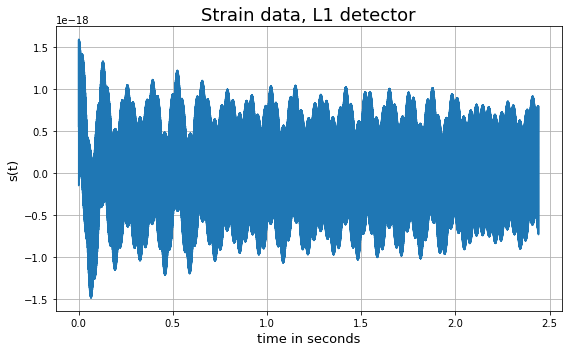

Number of points in time series: 16777216


<Figure size 432x288 with 0 Axes>

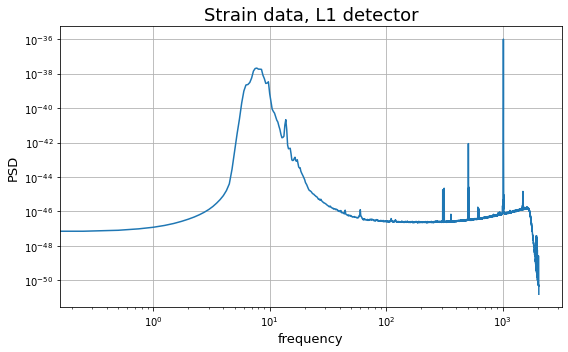

13830

<Figure size 432x288 with 0 Axes>

In [9]:
# ------> L1 detector

plt.figure(3, figsize=(8,5))
plt.plot(time_L1[:Nsamples], strain_noise_L1[:Nsamples])
plt.title("Strain data, L1 detector", fontsize=18)
plt.ylabel("s(t)", fontsize=13)
plt.xlabel("time in seconds", fontsize=13)
plt.grid()
plt.tight_layout()
plt.show()
print("Number of points in time series:", len(strain_noise_L1))
plt.figure(3).clear()
gc.collect()

plt.figure(4, figsize=(8,5))
#plt.plot(fpsd_L1, psd_L1, label='Scipy estimate')
plt.plot(fpsd_L1_pycbc, psd_L1_pycbc, label='PyCBC estimate')
plt.xscale('log')
plt.yscale('log')
plt.title("Strain data, L1 detector", fontsize=18)
plt.ylabel("PSD", fontsize=13)
plt.xlabel("frequency", fontsize=13)
plt.grid()
#plt.legend()
plt.tight_layout()
plt.show()
plt.figure(4).clear()
gc.collect()

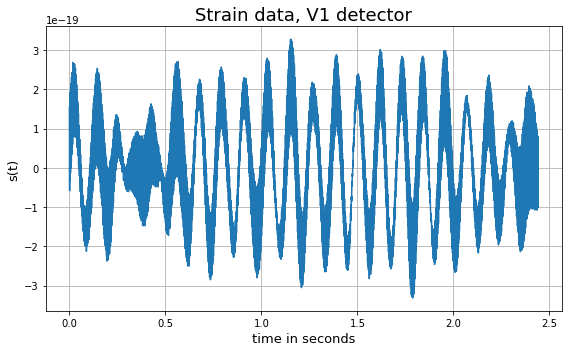

Number of points in time series: 16777216


<Figure size 432x288 with 0 Axes>

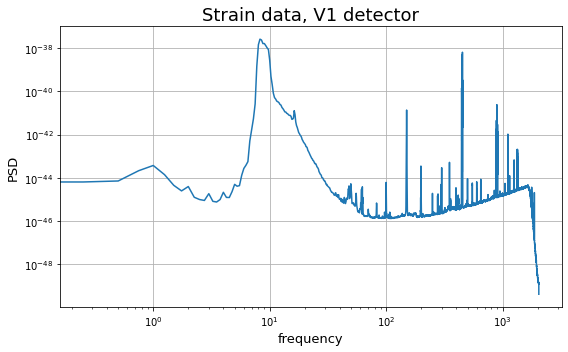

13287

<Figure size 432x288 with 0 Axes>

In [11]:
# ------> V1 detector

plt.figure(5, figsize=(8,5))
plt.plot(time_V1[:Nsamples], strain_noise_V1[:Nsamples])
plt.title("Strain data, V1 detector", fontsize=18)
plt.ylabel("s(t)", fontsize=13)
plt.xlabel("time in seconds", fontsize=13)
plt.grid()
plt.tight_layout()
plt.show()
print("Number of points in time series:", len(strain_noise_V1))
plt.figure(5).clear()
gc.collect()

plt.figure(6, figsize=(8,5))
#plt.plot(fpsd_V1, psd_V1, label='Scipy estimate')
plt.plot(fpsd_V1_pycbc, psd_V1_pycbc, label='PyCBC estimate')
plt.xscale('log')
plt.yscale('log')
plt.title("Strain data, V1 detector", fontsize=18)
plt.ylabel("PSD", fontsize=13)
plt.xlabel("frequency", fontsize=13)
plt.grid()
#plt.legend()
plt.tight_layout()
plt.show()
plt.figure(6).clear()
gc.collect()

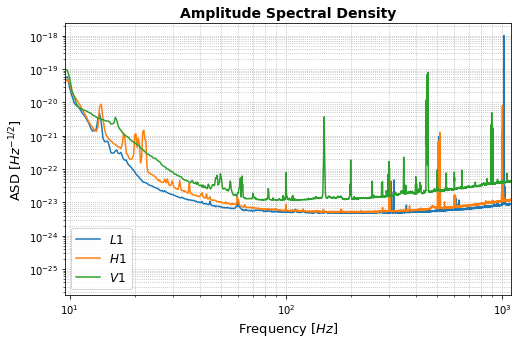

22201

<Figure size 432x288 with 0 Axes>

In [12]:
# ------> ASD for the three detectors (printable plot)

plt.figure(7, figsize=(8,5))
plt.plot(fpsd_L1_pycbc, np.sqrt(psd_L1_pycbc), label='$L1$')
plt.plot(fpsd_H1_pycbc, np.sqrt(psd_H1_pycbc), label='$H1$')
plt.plot(fpsd_V1_pycbc, np.sqrt(psd_V1_pycbc), label='$V1$')
plt.xscale('log')
plt.yscale('log')
plt.title("Amplitude Spectral Density", fontsize=14, fontweight="bold")
plt.ylabel("ASD [$Hz^{-1/2}]$", fontsize=13)
plt.xlabel("Frequency [$Hz$]", fontsize=13)
plt.xlim(left=9.5, right=1100)
plt.grid(which='both', linestyle=':')
plt.legend(fontsize=12)
#plt.savefig("../Figures/asd_detectors.pdf", format="pdf")
#plt.savefig("../Figures/asd_detectors.eps", format="eps")
plt.show()
plt.figure(7).clear()
gc.collect()

## 6. Save noise strain data

In [13]:
# Remark: Comment/Uncomment lines depending on your choice.

# ------> Strain data

# Convert int values to string
gps_H1 = "{}".format(gpsStart_H1)
gps_L1 = "{}".format(gpsStart_L1)
gps_V1 = "{}".format(gpsStart_V1)

# Save data
df = pd.DataFrame({"time" : time_H1, "strain" : strain_noise_H1})
df.to_csv("strain_noise_H1_" + gps_H1 + ".txt", index=False)

df = pd.DataFrame({"time" : time_L1, "strain" : strain_noise_L1})
df.to_csv("strain_noise_L1_" + gps_L1 + ".txt", index=False)

df = pd.DataFrame({"time" : time_V1, "strain" : strain_noise_V1})
df.to_csv("strain_noise_V1_" + gps_V1 + ".txt", index=False)